In [1]:
import os
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline
import time
from torch.autograd import Variable

import cv2
import torch
import numpy as np
from facenet_pytorch import MTCNN

import matplotlib.pyplot as plt

from PIL import Image

import glob
from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms

import torch.optim as optim

In [2]:
images = glob.glob('./leapGestRecog/**/**/*.png')

# extract label number from filename and reduce by 1 so that it ranges from 0 to 9 (instead of 1 to 10). Otherwise loss function will complain
labels = [int(os.path.basename(i).split('_')[2])-1 for i in images]
x_train, x_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

In [3]:
set(labels)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [4]:
images[0]

'./leapGestRecog\\00\\01_palm\\frame_00_01_0001.png'

In [5]:
def digit_to_classname(digit):
        if digit == 0:
            return 'palm'
        elif digit == 1:
            return 'l'
        elif digit == 2:
            return 'first'
        elif digit == 3:
            return 'fist_moved'
        elif digit == 4:
            return 'thumb'
        elif digit == 5:
            return 'index'
        elif digit == 6:
            return 'ok'
        elif digit == 7:
            return 'palm_moved'
        elif digit == 8:
            return 'c'
        elif digit == 9:
            return 'down'

In [6]:
class Image_Dataset(Dataset):
    def __init__(self, filenames, labels, transform):      
        self.filenames = filenames
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        image = Image.open(self.filenames[idx])
        image = self.transform(image)
        return image, self.labels[idx]

In [16]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 32, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(79680, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [25]:
train_transforms = tt.Compose([tt.Grayscale(num_output_channels=1), # Картинки чернобелые
                               transforms.Resize(64),
                         # Настройки для расширения датасета
                         tt.RandomHorizontalFlip(),           # Случайные повороты на 90 градусов
                         tt.RandomRotation(30),               # Случайные повороты на 30 градусов
                         tt.ToTensor()])                      # Приведение к тензору

test_transforms = tt.Compose([
                                tt.Grayscale(num_output_channels=1), 
                                transforms.Resize(64),
                                tt.ToTensor()])

In [26]:
train_dataset = Image_Dataset(x_train, y_train, train_transforms)
test_dataset = Image_Dataset(x_val, y_val, test_transforms)

In [36]:
np.unique(np.array(train_dataset[1][0]))

array([0.        , 0.01176471, 0.01568628, 0.01960784, 0.02352941,
       0.02745098, 0.03137255, 0.03529412, 0.03921569, 0.04313726,
       0.04705882, 0.05098039, 0.05490196, 0.05882353, 0.0627451 ,
       0.06666667, 0.07058824, 0.07450981, 0.07843138, 0.08235294,
       0.08627451, 0.09019608, 0.09411765, 0.09803922, 0.10196079,
       0.10588235, 0.10980392, 0.11372549, 0.11764706, 0.12156863,
       0.1254902 , 0.12941177, 0.13333334, 0.13725491, 0.14117648,
       0.14509805, 0.14901961, 0.15294118, 0.15686275, 0.16078432,
       0.16470589, 0.16862746, 0.1764706 , 0.18039216, 0.18431373,
       0.1882353 , 0.19215687, 0.19607843, 0.2       , 0.20392157,
       0.20784314, 0.21176471, 0.21568628, 0.22352941, 0.22745098,
       0.23137255, 0.23529412, 0.24313726, 0.2509804 , 0.25882354,
       0.2627451 , 0.26666668, 0.27058825, 0.27450982, 0.2784314 ,
       0.28235295, 0.28627452, 0.2901961 , 0.29411766, 0.29803923,
       0.3019608 , 0.30588236, 0.30980393, 0.3137255 , 0.31764

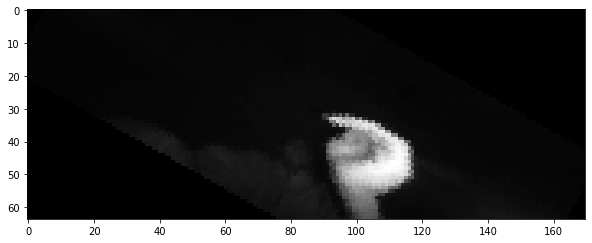

In [37]:
plt.figure(figsize = (10,10))
plt.imshow(np.array(train_dataset[1][0])[0,:,:], cmap='gray')

In [38]:
batch_size = 32
lr = 0.01
epochs = 30

max_lr = 0.008
grad_clip = 0.1
weight_decay = 1e-4

model = Net()

optimizer = optim.SGD(model.parameters(), lr=lr)

In [39]:
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size)

In [40]:
total_steps = len(train_dataloader)
print(f'{epochs} epochs, {total_steps} total_steps per epoch')

30 epochs, 500 total_steps per epoch


In [42]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    yhat = model(xb)
    loss = loss_func(yhat, yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        time1 = time.time()
        
        model.train()

        losses, nums = zip(
            *[loss_batch(model, loss_func, xb, yb, opt) for xb, yb in train_dl]
        )
    
        val_loss_train = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(f'Train Epoch: {epoch+1}, Train Loss: {val_loss_train}')
        time2 = time.time()
        print(f'Spend time: {time2 - time1} sec')
        
        if (epoch+1) % 10 == 0:
            model.eval()
            with torch.no_grad():
                losses, nums = zip(
                    *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
                )
            val_loss_test = np.sum(np.multiply(losses, nums)) / np.sum(nums)
            print(f'Test Loss: {val_loss_test}')

In [43]:
model = Net()
opt = optim.SGD(model.parameters(), lr=lr)
loss_func = F.cross_entropy

fit(epochs, model, loss_func, opt, train_dataloader, test_dataloader)

Train Epoch: 1, Train Loss: 2.11054349565506
Spend time: 924.6284046173096 sec
Train Epoch: 2, Train Loss: 1.6426347699165345
Spend time: 625.3459603786469 sec
Train Epoch: 3, Train Loss: 1.3769943006038665
Spend time: 632.5243291854858 sec
Train Epoch: 4, Train Loss: 1.1955134143829347
Spend time: 501.70449566841125 sec
Train Epoch: 5, Train Loss: 1.0918181087970733
Spend time: 709.5207803249359 sec
Train Epoch: 6, Train Loss: 0.9994611141681671
Spend time: 829.0041103363037 sec
Train Epoch: 7, Train Loss: 0.9300154468417168
Spend time: 872.7096605300903 sec
Train Epoch: 8, Train Loss: 0.8841674681901932
Spend time: 816.9555997848511 sec
Train Epoch: 9, Train Loss: 0.8320698983669281
Spend time: 722.2093725204468 sec
Train Epoch: 10, Train Loss: 0.7834830556511879
Spend time: 704.0666418075562 sec
Test Loss: 0.3574156104326248
Train Epoch: 11, Train Loss: 0.7569949890375137
Spend time: 715.9147021770477 sec
Train Epoch: 12, Train Loss: 0.728365396797657
Spend time: 734.2355773448944 s

In [44]:
torch.save(model.state_dict(), './models/hand_detection_model_state_30_epoch.pth')

C:\Users\march_000\anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  """


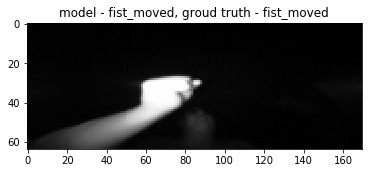

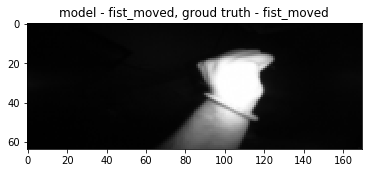

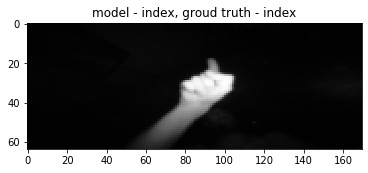

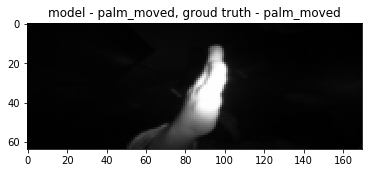

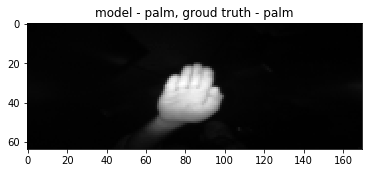

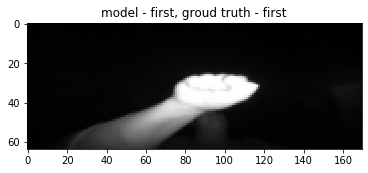

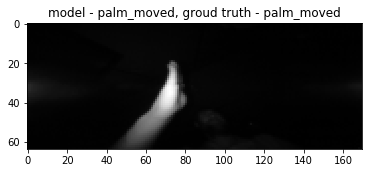

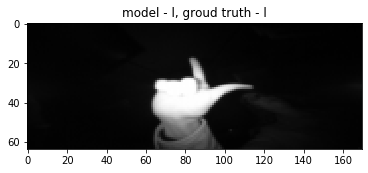

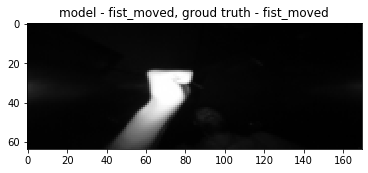

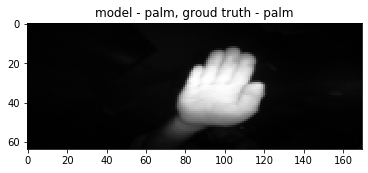

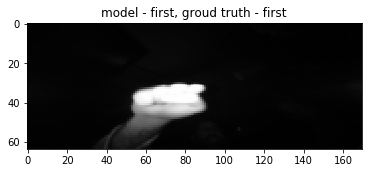

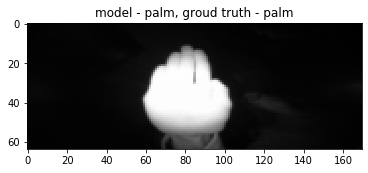

In [45]:
model.eval()
with torch.no_grad():
    for i, data in enumerate(test_dataloader):
        images, labels = data
        images, labels = Variable(images,volatile=True), Variable(labels,volatile=True)
        outputs = model(images)
        plt.title(f'model - {digit_to_classname(outputs[0].argmax())}, groud truth - {digit_to_classname(labels[0])}')
        plt.imshow(images[0].cpu().squeeze(), cmap='gray')
        plt.show()
        if i>10:
            break